# Simulation study

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from doubleml import DoubleMLData
from double_ml_ssm import DoubleMLSSM

from sklearn.linear_model import LassoCV, LogisticRegressionCV
from doubleml.double_ml_data import DoubleMLData
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from doubleml.datasets import make_ssm_data

In [2]:
def simulate_data_causalweight(n_obs, dim_x, score):
    """
    This function simulates the same DGP as used in a small simulation example in the implementation
    of the causalweight package. The true ATE is equal to 0.5.
    """
    c = 2  # number of covariates that are confounders
    if score=='missing-at-random':
        sigma = np.array([[1, 0], [0, 1]])
        gamma = 0
    else:
        sigma = np.array([[1, 0.5], [0.5, 1]])
        gamma = 0.25
    e = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=n_obs).T
    x = np.random.randn(n_obs, dim_x)  # covariate matrix
    beta = np.hstack((np.repeat(0.25, c), np.repeat(0, dim_x - c)))  # Coefficients determining the degree of confounding
    d = np.where(np.dot(x, beta) + np.random.randn(n_obs) > 0, 1, 0)  # Treatment equation
    z = np.random.randn(n_obs)
    s = np.where(np.dot(x, beta) + 0.25 * d + gamma * z + e[0] > 0, 1, 0)  # Selection equation
    y = np.dot(x, beta) + 0.5 * d + e[1]  # Outcome equation
    y[s == 0] = 0

    return x, y, d, s, z


def get_coefs(n_obs, dim_x, score, learner, learner_class):
    """
    Get estimated ATE coefficient.
    """
    x, y, d, s, z = simulate_data_causalweight(n_obs, dim_x, score)

    if score == 'missing-at-random':
        simul_data = DoubleMLData.from_arrays(x, y, d, z=None, t=s)
    else:
        simul_data = DoubleMLData.from_arrays(x, y, d, z=z, t=s)

    ml_g_sim = clone(learner)
    ml_pi_sim = clone(learner_class)
    ml_m_sim = clone(learner_class)

    obj_dml_sim = DoubleMLSSM(simul_data, ml_g_sim, ml_pi_sim, ml_m_sim, score=score)
    obj_dml_sim.fit()
    confint = obj_dml_sim.confint()

    return obj_dml_sim.coef[0], obj_dml_sim.se[0], confint['2.5 %'][0], confint['97.5 %'][0]


#### Missingness at random (MAR), single simulation

In [3]:
np.random.seed(42)
X, y, d, s, z = simulate_data_causalweight(8000, 100, 'missing-at-random')
simul_data = DoubleMLData.from_arrays(X, y, d, z=None, t=s)

learner = LassoCV()
learner_class = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_g_sim = clone(learner)
ml_pi_sim = clone(learner_class)
ml_m_sim = clone(learner_class)

np.random.seed(42)
obj_dml_sim = DoubleMLSSM(simul_data, ml_g_sim, ml_pi_sim, ml_m_sim, score='missing-at-random')
obj_dml_sim.fit()
print(obj_dml_sim)

================== DoubleMLSSM Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100']
Instrument variable(s): None
Time variable: t
No. Observations: 8000

------------------ Score & algorithm ------------------
Score 

#### Nonignorable nonresponse, single simulation

In [4]:
np.random.seed(42)
X, y, d, s, z = simulate_data_causalweight(8000, 50, 'nonignorable')
simul_data = DoubleMLData.from_arrays(X, y, d, z=z, t=s)

learner = LassoCV()
learner_class = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_g_sim = clone(learner)
ml_pi_sim = clone(learner_class)
ml_m_sim = clone(learner_class)

np.random.seed(42)
obj_dml_sim = DoubleMLSSM(simul_data, ml_g_sim, ml_pi_sim, ml_m_sim, score='nonignorable')
obj_dml_sim.fit()
print(obj_dml_sim)

================== DoubleMLSSM Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50']
Instrument variable(s): ['z']
Time variable: t
No. Observations: 8000

------------------ Score & algorithm ------------------
Score function: nonignorable
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: LassoCV()
Learner ml_pi: LogisticRegressionCV(penalty='l1', solver='liblinear')
Learner ml_m: LogisticRegressionCV(penalty='l1', solver='liblinear')
Out-of-sample Performance:
Learner ml_g_d0 RMSE: [[0.80035781]]
Learner ml_g_d1 RMSE: [

#### MAR, Multiple simulations

100%|██████████| 1000/1000 [1:35:49<00:00,  5.75s/it]

Average ATE estimate:  0.5057297744970441
Median ATE estimate:  0.5072687819745139
Standard deviation of ATE estimate:  0.03359759961307681


<AxesSubplot: xlabel='ATE estimate', ylabel='Count'>

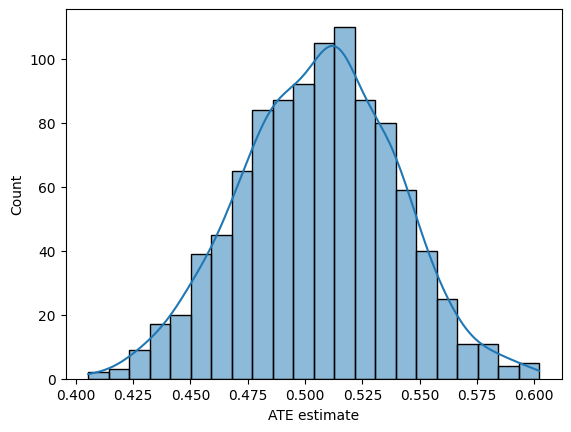

In [5]:
learner = LassoCV()
learner_class = LogisticRegressionCV(penalty='l1', solver='liblinear')
coefs = []
ses = []
ci = []

for i in tqdm(range(1000)):
    coef, se, cil, cih = get_coefs(8000, 50, 'missing-at-random', learner, learner_class)
    coefs.append(coef)
    ses.append(se)
    ci.append((cil, cih))

print("Average ATE estimate: ", np.mean(coefs))
print("Median ATE estimate: ", np.median(coefs))
print("Standard deviation of ATE estimate: ", np.std(coefs))
plt.xlabel('ATE estimate')
sns.histplot(coefs, kde=True)

<AxesSubplot: ylabel='Count'>

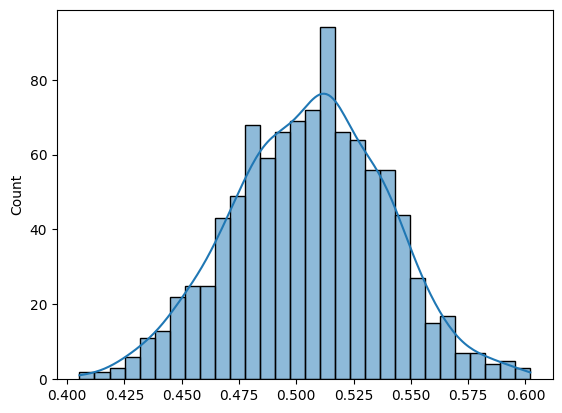

In [12]:
sns.histplot(coefs, kde=True, bins=30)

  1%|          | 9/1000 [01:18<2:22:46,  8.64s/it]/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/myska/.local/lib/python3.10/site-packages/sklearn/svm/_base

Average ATE estimate:  0.49878157936987827
Median ATE estimate:  0.49813719652642263
Standard deviation of ATE estimate:  0.03665354017620826


<AxesSubplot: xlabel='ATE estimate', ylabel='Count'>

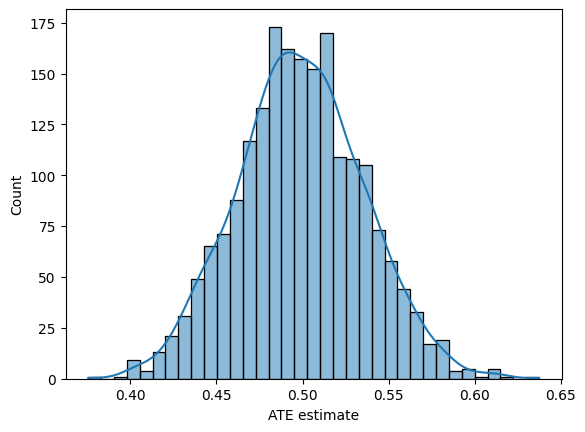

In [13]:
for i in tqdm(range(1000)):
    coef, se, cil, cih = get_coefs(8000, 20, 'nonignorable', learner, learner_class)
    coefs.append(coef)
    ses.append(se)
    ci.append((cil, cih))
    

print("Average ATE estimate: ", np.mean(coefs))
print("Median ATE estimate: ", np.median(coefs))
print("Standard deviation of ATE estimate: ", np.std(coefs))
plt.xlabel('ATE estimate')
sns.histplot(coefs, kde=True)

#### DGP from Appendix E of Bia, Huber and Lafférs (2023).

In [14]:
# True ATE is equal to 1
dml_data = make_ssm_data(n_obs=16000, mar=True)

In [15]:
learner = LassoCV()
learner_class = LogisticRegressionCV(penalty='l1', solver='liblinear')
ml_g_sim = clone(learner)
ml_pi_sim = clone(learner_class)
ml_m_sim = clone(learner_class)

# warning is expected to be raised after the following line is executed
obj_dml_sim = DoubleMLSSM(dml_data, ml_g_sim, ml_pi_sim, ml_m_sim, score='missing-at-random')
obj_dml_sim.fit()
print(obj_dml_sim.summary)

       coef   std err        t  P>|t|     2.5 %    97.5 %
d  1.038813  0.021615  48.0601    0.0  0.996449  1.081177


In [16]:
dml_data = make_ssm_data(n_obs=16000, mar=False)

ml_g_sim = clone(learner)
ml_pi_sim = clone(learner_class)
ml_m_sim = clone(learner_class)

obj_dml_sim = DoubleMLSSM(dml_data, ml_g_sim, ml_pi_sim, ml_m_sim, score='nonignorable')
obj_dml_sim.fit()
print(obj_dml_sim.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
d  0.971989  0.026919  36.107281  1.743413e-285  0.919228  1.024751


In [17]:
coefs = []
ses = []
confints = []

for i in tqdm(range(100)):
    dml_data = make_ssm_data(n_obs=8000, mar=True)
    ml_g_sim = clone(learner)
    ml_pi_sim = clone(learner_class)
    ml_m_sim = clone(learner_class)

    obj_dml_sim = DoubleMLSSM(dml_data, ml_g_sim, ml_pi_sim, ml_m_sim, score='missing-at-random')
    obj_dml_sim.fit()
    confint = obj_dml_sim.confint()
    coefs.append(obj_dml_sim.summary['coef'][0])
    ses.append(obj_dml_sim.summary['std err'][0])
    confints.append((confint['2.5 %'][0], confint['97.5 %'][0]))

100%|██████████| 100/100 [17:20<00:00, 10.40s/it]


Average ATE estimate:  1.003545568875059
Median ATE estimate:  1.0043647130139526
Mean standard deviation of ATE estimate:  0.03105123781716652
Confint:  (0.9458032016444089, 1.0604203894891184)


<AxesSubplot: xlabel='ATE estimate', ylabel='Count'>

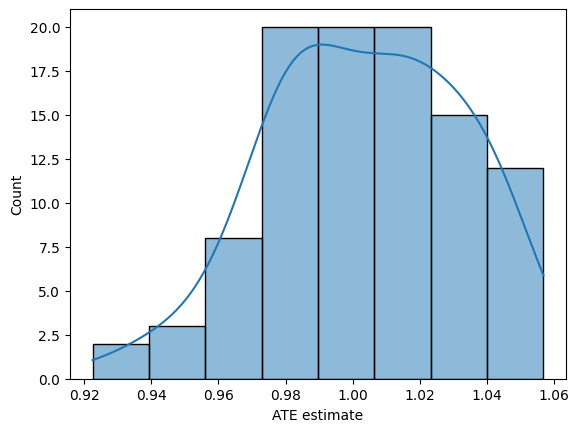

In [18]:
print("Average ATE estimate: ", np.mean(coefs))
print("Median ATE estimate: ", np.median(coefs))
print("Mean standard deviation of ATE estimate: ", np.mean(ses))
print("Confint: ", confints[0])
plt.xlabel('ATE estimate')
sns.histplot(coefs, kde=True)